# SWELL HRV Synthetic Data Generation with Conditional TimeGAN
## Mental Health - Stress Detection Project

**Important**: This notebook maintains proper sequential order of time-series data.
- No random shuffling of sequences
- Proper temporal dependencies preserved
- Train/test split by participant, not random

## 1. Setup and Imports

In [ ]:
# Install required packages (run once)
!pip install torch torchvision numpy pandas scikit-learn matplotlib seaborn tqdm -q

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Preprocess Data (SEQUENTIAL - NO RANDOM SHUFFLING)

In [ ]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nCondition distribution in train:")
print(train_df['condition'].value_counts())
print(f"\nCondition distribution in test:")
print(test_df['condition'].value_counts())

Train shape: (369289, 36)
Test shape: (41033, 36)

Condition distribution in train:
condition
no stress        200082
interruption     105150
time pressure     64057
Name: count, dtype: int64

Condition distribution in test:
condition
no stress        22158
interruption     11782
time pressure     7093
Name: count, dtype: int64


In [ ]:
# Encode conditions
label_encoder = LabelEncoder()
train_df['condition_encoded'] = label_encoder.fit_transform(train_df['condition'])
test_df['condition_encoded'] = label_encoder.transform(test_df['condition'])

condition_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Condition mapping:", condition_mapping)

# Separate features and labels
feature_columns = train_df.columns[:-2]  # All except 'condition' and 'condition_encoded'
n_features = len(feature_columns)
print(f"\nNumber of features: {n_features}")
print(f"Feature columns: {list(feature_columns[:5])}...")

Condition mapping: {'interruption': np.int64(0), 'no stress': np.int64(1), 'time pressure': np.int64(2)}

Number of features: 35
Feature columns: ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD']...


In [ ]:
# Normalize features (fit on train only)
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_columns])
test_features = scaler.transform(test_df[feature_columns])

train_labels = train_df['condition_encoded'].values
test_labels = test_df['condition_encoded'].values

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (369289, 35)
Test features shape: (41033, 35)


## 3. Create Sequential Windows (MAINTAINING TEMPORAL ORDER)

In [ ]:
def create_sequences(features, labels, seq_length=10, stride=5):
    """
    Create sequences MAINTAINING TEMPORAL ORDER.
    Each sequence is 'seq_length' consecutive timesteps.

    CRITICAL: We use stride to create overlapping windows but maintain order!
    """
    sequences = []
    sequence_labels = []

    # Group by condition to keep same-condition data together
    for condition in np.unique(labels):
        condition_mask = labels == condition
        condition_features = features[condition_mask]

        # Create sequences from this condition's data IN ORDER
        for i in range(0, len(condition_features) - seq_length + 1, stride):
            seq = condition_features[i:i+seq_length]
            sequences.append(seq)
            sequence_labels.append(condition)

    return np.array(sequences), np.array(sequence_labels)

# Create sequences
SEQ_LENGTH = 10  # 10 minutes window
STRIDE = 5       # 50% overlap

print("Creating sequential windows...")
train_sequences, train_seq_labels = create_sequences(train_features, train_labels, SEQ_LENGTH, STRIDE)
test_sequences, test_seq_labels = create_sequences(test_features, test_labels, SEQ_LENGTH, STRIDE)

print(f"\nTrain sequences shape: {train_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print(f"Each sequence: [{SEQ_LENGTH} timesteps] x [{n_features} features]")

Creating sequential windows...

Train sequences shape: (73854, 10, 35)
Test sequences shape: (8202, 10, 35)
Each sequence: [10 timesteps] x [35 features]


## 4. Conditional TimeGAN Architecture

In [ ]:
class ConditionalTimeGAN(nn.Module):
    """Conditional TimeGAN for time-series synthesis with condition control"""

    def __init__(self, input_dim, hidden_dim, num_layers, num_conditions, seq_len):
        super(ConditionalTimeGAN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_conditions = num_conditions
        self.seq_len = seq_len

        # Embedder Network (for real data)
        self.embedder = nn.LSTM(input_dim + num_conditions, hidden_dim, num_layers,
                               batch_first=True, dropout=0.3)
        self.embedder_fc = nn.Linear(hidden_dim, hidden_dim)

        # Recovery Network (reconstruct from embedding)
        self.recovery = nn.LSTM(hidden_dim, hidden_dim, num_layers,
                               batch_first=True, dropout=0.3)
        self.recovery_fc = nn.Linear(hidden_dim, input_dim)

        # Generator Network (generate synthetic embeddings)
        self.generator = nn.LSTM(input_dim + num_conditions, hidden_dim, num_layers,
                                batch_first=True, dropout=0.3)
        self.generator_fc = nn.Linear(hidden_dim, hidden_dim)

        # Discriminator Network (distinguish real vs synthetic)
        self.discriminator = nn.LSTM(hidden_dim, hidden_dim, num_layers,
                                    batch_first=True, dropout=0.3)
        self.discriminator_fc = nn.Linear(hidden_dim, 1)

    def embed(self, x, condition):
        """Embed real data to latent space"""
        # Concatenate condition
        condition_expanded = condition.unsqueeze(1).expand(-1, self.seq_len, -1)
        x_cond = torch.cat([x, condition_expanded], dim=-1)

        h, _ = self.embedder(x_cond)
        h = torch.sigmoid(self.embedder_fc(h))
        return h

    def recover(self, h):
        """Recover data from latent space"""
        x, _ = self.recovery(h)
        x = self.recovery_fc(x)
        return x

    def generate(self, z, condition):
        """Generate synthetic embeddings from noise"""
        # Concatenate condition
        condition_expanded = condition.unsqueeze(1).expand(-1, self.seq_len, -1)
        z_cond = torch.cat([z, condition_expanded], dim=-1)

        h, _ = self.generator(z_cond)
        h = torch.sigmoid(self.generator_fc(h))
        return h

    def discriminate(self, h):
        """Discriminate between real and synthetic embeddings"""
        y, _ = self.discriminator(h)
        y = torch.sigmoid(self.discriminator_fc(y))
        return y

    def forward(self, x, z, condition):
        """Full forward pass for training"""
        # Real data path
        h_real = self.embed(x, condition)
        x_tilde = self.recover(h_real)

        # Synthetic data path
        h_fake = self.generate(z, condition)
        x_fake = self.recover(h_fake)

        # Discrimination
        y_real = self.discriminate(h_real)
        y_fake = self.discriminate(h_fake)

        return x_tilde, x_fake, y_real, y_fake, h_real, h_fake

## 5. Training the Conditional TimeGAN

In [ ]:
# Hyperparameters
HIDDEN_DIM = 128
NUM_LAYERS = 2
NUM_CONDITIONS = len(np.unique(train_seq_labels))
BATCH_SIZE = 128
EPOCHS = 60  # Adjust based on time constraints
LEARNING_RATE = 0.001

# Initialize model
model = ConditionalTimeGAN(
    input_dim=n_features,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_conditions=NUM_CONDITIONS,
    seq_len=SEQ_LENGTH
).to(device)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Model initialized with 1002276 parameters


In [ ]:
# Dataset (NO SHUFFLING in DataLoader!)
class SequentialDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = SequentialDataset(train_sequences, train_seq_labels)
# CRITICAL: shuffle=False to maintain sequential order!
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")

Training batches: 577


In [ ]:
# Optimizers
optimizer_embedder = optim.Adam(list(model.embedder.parameters()) +
                                list(model.embedder_fc.parameters()) +
                                list(model.recovery.parameters()) +
                                list(model.recovery_fc.parameters()),
                                lr=LEARNING_RATE)

optimizer_generator = optim.Adam(list(model.generator.parameters()) +
                                 list(model.generator_fc.parameters()),
                                 lr=LEARNING_RATE)

optimizer_discriminator = optim.Adam(list(model.discriminator.parameters()) +
                                     list(model.discriminator_fc.parameters()),
                                     lr=LEARNING_RATE)

# Loss functions
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

In [ ]:
# Training loop
def train_timegan(model, train_loader, epochs):
    """
    Train TimeGAN with proper sequential handling.
    """
    history = {'embedder_loss': [], 'generator_loss': [], 'discriminator_loss': []}

    for epoch in range(epochs):
        model.train()
        epoch_e_loss = 0
        epoch_g_loss = 0
        epoch_d_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (x_real, conditions) in enumerate(pbar):
            x_real = x_real.to(device)
            batch_size = x_real.size(0)

            # One-hot encode conditions
            condition_onehot = torch.zeros(batch_size, NUM_CONDITIONS).to(device)
            condition_onehot.scatter_(1, conditions.unsqueeze(1).to(device), 1)

            # Random noise for generator
            z = torch.randn(batch_size, SEQ_LENGTH, n_features).to(device)

            # --- Phase 1: Train Embedder (Autoencoder) ---
            optimizer_embedder.zero_grad()
            h_real = model.embed(x_real, condition_onehot)
            x_tilde = model.recover(h_real)
            e_loss = mse_loss(x_tilde, x_real)
            e_loss.backward()
            optimizer_embedder.step()

            # --- Phase 2: Train Generator ---
            optimizer_generator.zero_grad()
            h_fake = model.generate(z, condition_onehot)
            h_real_detached = model.embed(x_real, condition_onehot).detach()
            y_fake_g = model.discriminate(h_fake)

            g_loss_u = bce_loss(y_fake_g, torch.ones_like(y_fake_g))  # Fool discriminator
            g_loss_s = mse_loss(torch.mean(h_fake, dim=0), torch.mean(h_real_detached, dim=0))  # Match moments
            g_loss = g_loss_u + 100 * g_loss_s
            g_loss.backward()
            optimizer_generator.step()

            # --- Phase 3: Train Discriminator ---
            optimizer_discriminator.zero_grad()
            h_fake_detached = model.generate(z, condition_onehot).detach()
            h_real_detached = model.embed(x_real, condition_onehot).detach()

            y_real = model.discriminate(h_real_detached)
            y_fake = model.discriminate(h_fake_detached)

            d_loss_real = bce_loss(y_real, torch.ones_like(y_real))
            d_loss_fake = bce_loss(y_fake, torch.zeros_like(y_fake))
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_discriminator.step()

            epoch_e_loss += e_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

            pbar.set_postfix({
                'E_loss': f'{e_loss.item():.4f}',
                'G_loss': f'{g_loss.item():.4f}',
                'D_loss': f'{d_loss.item():.4f}'
            })

        # Record losses
        history['embedder_loss'].append(epoch_e_loss / len(train_loader))
        history['generator_loss'].append(epoch_g_loss / len(train_loader))
        history['discriminator_loss'].append(epoch_d_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{epochs} - E_loss: {history['embedder_loss'][-1]:.4f}, "
              f"G_loss: {history['generator_loss'][-1]:.4f}, D_loss: {history['discriminator_loss'][-1]:.4f}")

    return history

print("Starting training...")
history = train_timegan(model, train_loader, EPOCHS)
print("Training completed!")

Starting training...


Epoch 1/60: 100%|██████████| 577/577 [00:11<00:00, 48.26it/s, E_loss=0.1259, G_loss=0.8126, D_loss=1.2591]


Epoch 1/60 - E_loss: 0.3533, G_loss: 1.4222, D_loss: 1.1353


Epoch 2/60: 100%|██████████| 577/577 [00:11<00:00, 52.42it/s, E_loss=0.0993, G_loss=0.8687, D_loss=1.3814]


Epoch 2/60 - E_loss: 0.1302, G_loss: 0.9600, D_loss: 1.2644


Epoch 3/60: 100%|██████████| 577/577 [00:10<00:00, 52.62it/s, E_loss=0.0786, G_loss=0.8004, D_loss=1.4060]


Epoch 3/60 - E_loss: 0.1003, G_loss: 0.7783, D_loss: 1.3630


Epoch 4/60: 100%|██████████| 577/577 [00:11<00:00, 52.05it/s, E_loss=0.0644, G_loss=0.7098, D_loss=1.3787]


Epoch 4/60 - E_loss: 0.0803, G_loss: 0.7566, D_loss: 1.3775


Epoch 5/60: 100%|██████████| 577/577 [00:11<00:00, 49.45it/s, E_loss=0.0539, G_loss=0.7044, D_loss=1.3855]


Epoch 5/60 - E_loss: 0.0657, G_loss: 0.7447, D_loss: 1.3749


Epoch 6/60: 100%|██████████| 577/577 [00:12<00:00, 48.07it/s, E_loss=0.0489, G_loss=0.7224, D_loss=1.3640]


Epoch 6/60 - E_loss: 0.0585, G_loss: 0.7234, D_loss: 1.3831


Epoch 7/60: 100%|██████████| 577/577 [00:12<00:00, 45.28it/s, E_loss=0.0441, G_loss=0.7341, D_loss=1.3690]


Epoch 7/60 - E_loss: 0.0542, G_loss: 0.7440, D_loss: 1.3765


Epoch 8/60: 100%|██████████| 577/577 [00:11<00:00, 51.91it/s, E_loss=0.0415, G_loss=0.7206, D_loss=1.3715]


Epoch 8/60 - E_loss: 0.0512, G_loss: 0.7401, D_loss: 1.3781


Epoch 9/60: 100%|██████████| 577/577 [00:11<00:00, 51.40it/s, E_loss=0.0407, G_loss=0.7438, D_loss=1.3737]


Epoch 9/60 - E_loss: 0.0488, G_loss: 0.7436, D_loss: 1.3789


Epoch 10/60: 100%|██████████| 577/577 [00:11<00:00, 51.81it/s, E_loss=0.0392, G_loss=0.7907, D_loss=1.3470]


Epoch 10/60 - E_loss: 0.0465, G_loss: 0.7537, D_loss: 1.3758


Epoch 11/60: 100%|██████████| 577/577 [00:10<00:00, 53.20it/s, E_loss=0.0359, G_loss=0.7783, D_loss=1.3682]


Epoch 11/60 - E_loss: 0.0436, G_loss: 0.7448, D_loss: 1.3788


Epoch 12/60: 100%|██████████| 577/577 [00:11<00:00, 52.40it/s, E_loss=0.0350, G_loss=0.7388, D_loss=1.3077]


Epoch 12/60 - E_loss: 0.0413, G_loss: 0.7501, D_loss: 1.3739


Epoch 13/60: 100%|██████████| 577/577 [00:11<00:00, 50.67it/s, E_loss=0.0342, G_loss=0.9382, D_loss=1.2878]


Epoch 13/60 - E_loss: 0.0395, G_loss: 0.8044, D_loss: 1.3519


Epoch 14/60: 100%|██████████| 577/577 [00:11<00:00, 50.18it/s, E_loss=0.0332, G_loss=0.7917, D_loss=1.3504]


Epoch 14/60 - E_loss: 0.0377, G_loss: 0.8020, D_loss: 1.3619


Epoch 15/60: 100%|██████████| 577/577 [00:11<00:00, 50.77it/s, E_loss=0.0308, G_loss=0.9099, D_loss=1.2431]


Epoch 15/60 - E_loss: 0.0354, G_loss: 0.8395, D_loss: 1.3380


Epoch 16/60: 100%|██████████| 577/577 [00:11<00:00, 50.91it/s, E_loss=0.0290, G_loss=0.7334, D_loss=1.4009]


Epoch 16/60 - E_loss: 0.0332, G_loss: 0.8182, D_loss: 1.3485


Epoch 17/60: 100%|██████████| 577/577 [00:11<00:00, 50.58it/s, E_loss=0.0273, G_loss=0.7947, D_loss=1.4097]


Epoch 17/60 - E_loss: 0.0315, G_loss: 0.8466, D_loss: 1.3327


Epoch 18/60: 100%|██████████| 577/577 [00:11<00:00, 50.64it/s, E_loss=0.0278, G_loss=0.9700, D_loss=1.1717]


Epoch 18/60 - E_loss: 0.0303, G_loss: 0.9146, D_loss: 1.2985


Epoch 19/60: 100%|██████████| 577/577 [00:11<00:00, 50.50it/s, E_loss=0.0254, G_loss=0.9884, D_loss=1.2548]


Epoch 19/60 - E_loss: 0.0291, G_loss: 0.9046, D_loss: 1.3131


Epoch 20/60: 100%|██████████| 577/577 [00:11<00:00, 51.01it/s, E_loss=0.0247, G_loss=1.0102, D_loss=1.3416]


Epoch 20/60 - E_loss: 0.0282, G_loss: 0.8705, D_loss: 1.3258


Epoch 21/60: 100%|██████████| 577/577 [00:11<00:00, 50.67it/s, E_loss=0.0248, G_loss=0.9811, D_loss=1.2909]


Epoch 21/60 - E_loss: 0.0272, G_loss: 0.9175, D_loss: 1.3029


Epoch 22/60: 100%|██████████| 577/577 [00:11<00:00, 51.34it/s, E_loss=0.0232, G_loss=1.0139, D_loss=1.2155]


Epoch 22/60 - E_loss: 0.0262, G_loss: 0.9680, D_loss: 1.2663


Epoch 23/60: 100%|██████████| 577/577 [00:11<00:00, 51.72it/s, E_loss=0.0220, G_loss=1.0545, D_loss=1.3275]


Epoch 23/60 - E_loss: 0.0252, G_loss: 0.9021, D_loss: 1.3075


Epoch 24/60: 100%|██████████| 577/577 [00:11<00:00, 51.32it/s, E_loss=0.0223, G_loss=1.0387, D_loss=1.2983]


Epoch 24/60 - E_loss: 0.0246, G_loss: 0.9359, D_loss: 1.2945


Epoch 25/60: 100%|██████████| 577/577 [00:11<00:00, 50.86it/s, E_loss=0.0214, G_loss=0.8838, D_loss=1.3300]


Epoch 25/60 - E_loss: 0.0239, G_loss: 0.9720, D_loss: 1.2823


Epoch 26/60: 100%|██████████| 577/577 [00:11<00:00, 51.24it/s, E_loss=0.0203, G_loss=1.1772, D_loss=1.2877]


Epoch 26/60 - E_loss: 0.0232, G_loss: 1.0219, D_loss: 1.2546


Epoch 27/60: 100%|██████████| 577/577 [00:11<00:00, 51.34it/s, E_loss=0.0202, G_loss=1.1701, D_loss=1.1417]


Epoch 27/60 - E_loss: 0.0228, G_loss: 1.0146, D_loss: 1.2595


Epoch 28/60: 100%|██████████| 577/577 [00:11<00:00, 51.24it/s, E_loss=0.0206, G_loss=1.2504, D_loss=1.2371]


Epoch 28/60 - E_loss: 0.0221, G_loss: 1.1089, D_loss: 1.2170


Epoch 29/60: 100%|██████████| 577/577 [00:11<00:00, 51.34it/s, E_loss=0.0187, G_loss=1.5642, D_loss=1.1668]


Epoch 29/60 - E_loss: 0.0216, G_loss: 1.0487, D_loss: 1.2498


Epoch 30/60: 100%|██████████| 577/577 [00:11<00:00, 51.27it/s, E_loss=0.0190, G_loss=1.0781, D_loss=1.2448]


Epoch 30/60 - E_loss: 0.0212, G_loss: 1.0454, D_loss: 1.2503


Epoch 31/60: 100%|██████████| 577/577 [00:11<00:00, 50.92it/s, E_loss=0.0189, G_loss=1.4101, D_loss=1.1259]


Epoch 31/60 - E_loss: 0.0208, G_loss: 1.0660, D_loss: 1.2358


Epoch 32/60: 100%|██████████| 577/577 [00:11<00:00, 50.35it/s, E_loss=0.0186, G_loss=1.3227, D_loss=1.0180]


Epoch 32/60 - E_loss: 0.0204, G_loss: 1.1670, D_loss: 1.2011


Epoch 33/60: 100%|██████████| 577/577 [00:11<00:00, 50.25it/s, E_loss=0.0182, G_loss=1.1608, D_loss=1.1077]


Epoch 33/60 - E_loss: 0.0200, G_loss: 1.1892, D_loss: 1.1932


Epoch 34/60: 100%|██████████| 577/577 [00:11<00:00, 51.59it/s, E_loss=0.0173, G_loss=1.4773, D_loss=1.0428]


Epoch 34/60 - E_loss: 0.0196, G_loss: 1.1283, D_loss: 1.2064


Epoch 35/60: 100%|██████████| 577/577 [00:11<00:00, 51.44it/s, E_loss=0.0176, G_loss=1.3858, D_loss=0.9783]


Epoch 35/60 - E_loss: 0.0193, G_loss: 1.1717, D_loss: 1.1900


Epoch 36/60: 100%|██████████| 577/577 [00:11<00:00, 50.51it/s, E_loss=0.0166, G_loss=1.2082, D_loss=1.1554]


Epoch 36/60 - E_loss: 0.0190, G_loss: 1.2064, D_loss: 1.1867


Epoch 37/60: 100%|██████████| 577/577 [00:11<00:00, 50.82it/s, E_loss=0.0170, G_loss=1.5262, D_loss=0.9331]


Epoch 37/60 - E_loss: 0.0187, G_loss: 1.2608, D_loss: 1.1544


Epoch 38/60: 100%|██████████| 577/577 [00:11<00:00, 50.88it/s, E_loss=0.0165, G_loss=1.3382, D_loss=0.9480]


Epoch 38/60 - E_loss: 0.0184, G_loss: 1.2176, D_loss: 1.1795


Epoch 39/60: 100%|██████████| 577/577 [00:11<00:00, 50.38it/s, E_loss=0.0162, G_loss=1.4398, D_loss=1.0377]


Epoch 39/60 - E_loss: 0.0181, G_loss: 1.1830, D_loss: 1.1867


Epoch 40/60: 100%|██████████| 577/577 [00:11<00:00, 50.37it/s, E_loss=0.0159, G_loss=1.3332, D_loss=1.0397]


Epoch 40/60 - E_loss: 0.0178, G_loss: 1.2586, D_loss: 1.1588


Epoch 41/60: 100%|██████████| 577/577 [00:11<00:00, 49.99it/s, E_loss=0.0161, G_loss=1.4500, D_loss=1.2854]


Epoch 41/60 - E_loss: 0.0176, G_loss: 1.2801, D_loss: 1.1426


Epoch 42/60: 100%|██████████| 577/577 [00:11<00:00, 50.38it/s, E_loss=0.0162, G_loss=1.5821, D_loss=0.9642]


Epoch 42/60 - E_loss: 0.0174, G_loss: 1.2853, D_loss: 1.1382


Epoch 43/60: 100%|██████████| 577/577 [00:11<00:00, 50.58it/s, E_loss=0.0154, G_loss=1.6579, D_loss=0.9380]


Epoch 43/60 - E_loss: 0.0171, G_loss: 1.2645, D_loss: 1.1540


Epoch 44/60: 100%|██████████| 577/577 [00:11<00:00, 50.32it/s, E_loss=0.0154, G_loss=1.5089, D_loss=0.9757]


Epoch 44/60 - E_loss: 0.0169, G_loss: 1.3269, D_loss: 1.1286


Epoch 45/60: 100%|██████████| 577/577 [00:11<00:00, 50.45it/s, E_loss=0.0157, G_loss=2.1150, D_loss=0.8765]


Epoch 45/60 - E_loss: 0.0167, G_loss: 1.3908, D_loss: 1.1004


Epoch 46/60: 100%|██████████| 577/577 [00:11<00:00, 51.48it/s, E_loss=0.0150, G_loss=1.7122, D_loss=0.9562]


Epoch 46/60 - E_loss: 0.0165, G_loss: 1.3874, D_loss: 1.1096


Epoch 47/60: 100%|██████████| 577/577 [00:11<00:00, 51.35it/s, E_loss=0.0150, G_loss=1.7815, D_loss=1.0083]


Epoch 47/60 - E_loss: 0.0163, G_loss: 1.3584, D_loss: 1.1058


Epoch 48/60: 100%|██████████| 577/577 [00:11<00:00, 50.84it/s, E_loss=0.0144, G_loss=2.2609, D_loss=0.7052]


Epoch 48/60 - E_loss: 0.0161, G_loss: 1.4445, D_loss: 1.0770


Epoch 49/60: 100%|██████████| 577/577 [00:11<00:00, 50.14it/s, E_loss=0.0143, G_loss=1.9233, D_loss=0.9206]


Epoch 49/60 - E_loss: 0.0160, G_loss: 1.5538, D_loss: 1.0376


Epoch 50/60: 100%|██████████| 577/577 [00:11<00:00, 50.04it/s, E_loss=0.0141, G_loss=1.7732, D_loss=0.8762]


Epoch 50/60 - E_loss: 0.0159, G_loss: 1.5861, D_loss: 1.0118


Epoch 51/60: 100%|██████████| 577/577 [00:11<00:00, 50.25it/s, E_loss=0.0140, G_loss=2.2693, D_loss=0.9652]


Epoch 51/60 - E_loss: 0.0156, G_loss: 1.6758, D_loss: 0.9778


Epoch 52/60: 100%|██████████| 577/577 [00:11<00:00, 50.84it/s, E_loss=0.0143, G_loss=2.1343, D_loss=0.8881]


Epoch 52/60 - E_loss: 0.0155, G_loss: 1.6580, D_loss: 0.9872


Epoch 53/60: 100%|██████████| 577/577 [00:11<00:00, 50.98it/s, E_loss=0.0139, G_loss=2.0333, D_loss=0.7530]


Epoch 53/60 - E_loss: 0.0153, G_loss: 1.6826, D_loss: 0.9727


Epoch 54/60: 100%|██████████| 577/577 [00:11<00:00, 50.71it/s, E_loss=0.0142, G_loss=2.2276, D_loss=0.8723]


Epoch 54/60 - E_loss: 0.0152, G_loss: 1.7833, D_loss: 0.9492


Epoch 55/60: 100%|██████████| 577/577 [00:11<00:00, 51.04it/s, E_loss=0.0136, G_loss=2.4628, D_loss=0.8943]


Epoch 55/60 - E_loss: 0.0150, G_loss: 1.8215, D_loss: 0.9331


Epoch 56/60: 100%|██████████| 577/577 [00:11<00:00, 50.80it/s, E_loss=0.0139, G_loss=2.1655, D_loss=0.7893]


Epoch 56/60 - E_loss: 0.0149, G_loss: 1.8576, D_loss: 0.9208


Epoch 57/60: 100%|██████████| 577/577 [00:11<00:00, 50.72it/s, E_loss=0.0136, G_loss=2.1554, D_loss=0.7531]


Epoch 57/60 - E_loss: 0.0148, G_loss: 1.9780, D_loss: 0.8808


Epoch 58/60: 100%|██████████| 577/577 [00:11<00:00, 52.02it/s, E_loss=0.0133, G_loss=2.1894, D_loss=0.7124]


Epoch 58/60 - E_loss: 0.0146, G_loss: 2.0153, D_loss: 0.8783


Epoch 59/60: 100%|██████████| 577/577 [00:11<00:00, 51.44it/s, E_loss=0.0133, G_loss=2.7186, D_loss=0.5989]


Epoch 59/60 - E_loss: 0.0145, G_loss: 2.0765, D_loss: 0.8452


Epoch 60/60: 100%|██████████| 577/577 [00:11<00:00, 50.11it/s, E_loss=0.0130, G_loss=2.4453, D_loss=0.7444]

Epoch 60/60 - E_loss: 0.0143, G_loss: 2.0934, D_loss: 0.8414
Training completed!


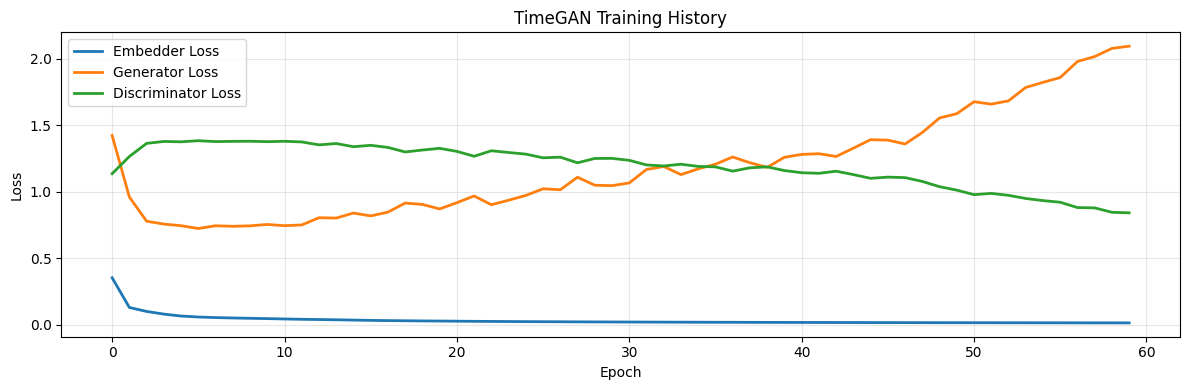

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history['embedder_loss'], label='Embedder Loss', linewidth=2)
plt.plot(history['generator_loss'], label='Generator Loss', linewidth=2)
plt.plot(history['discriminator_loss'], label='Discriminator Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TimeGAN Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Generate Synthetic Data

In [ ]:
def generate_synthetic_data(model, num_samples, condition_label, seq_len, n_features):
    """
    Generate synthetic sequences for a specific condition.
    """
    model.eval()
    with torch.no_grad():
        # Create condition one-hot
        condition_onehot = torch.zeros(num_samples, NUM_CONDITIONS).to(device)
        condition_onehot[:, condition_label] = 1

        # Generate random noise
        z = torch.randn(num_samples, seq_len, n_features).to(device)

        # Generate synthetic embeddings
        h_synthetic = model.generate(z, condition_onehot)

        # Recover to data space
        x_synthetic = model.recover(h_synthetic)

        return x_synthetic.cpu().numpy()

# Generate synthetic data for each condition
print("Generating synthetic data...")
synthetic_sequences = []
synthetic_labels = []

samples_per_condition = len(train_sequences) // NUM_CONDITIONS

for condition_idx in range(NUM_CONDITIONS):
    print(f"Generating {samples_per_condition} samples for condition {condition_idx} ({label_encoder.inverse_transform([condition_idx])[0]})...")
    synth_data = generate_synthetic_data(model, samples_per_condition, condition_idx, SEQ_LENGTH, n_features)
    synthetic_sequences.append(synth_data)
    synthetic_labels.extend([condition_idx] * samples_per_condition)

synthetic_sequences = np.vstack(synthetic_sequences)
synthetic_labels = np.array(synthetic_labels)

print(f"\nGenerated {len(synthetic_sequences)} synthetic sequences")
print(f"Shape: {synthetic_sequences.shape}")
print(f"Labels distribution: {np.bincount(synthetic_labels)}")

Generating synthetic data...
Generating 24618 samples for condition 0 (interruption)...
Generating 24618 samples for condition 1 (no stress)...
Generating 24618 samples for condition 2 (time pressure)...

Generated 73854 synthetic sequences
Shape: (73854, 10, 35)
Labels distribution: [24618 24618 24618]


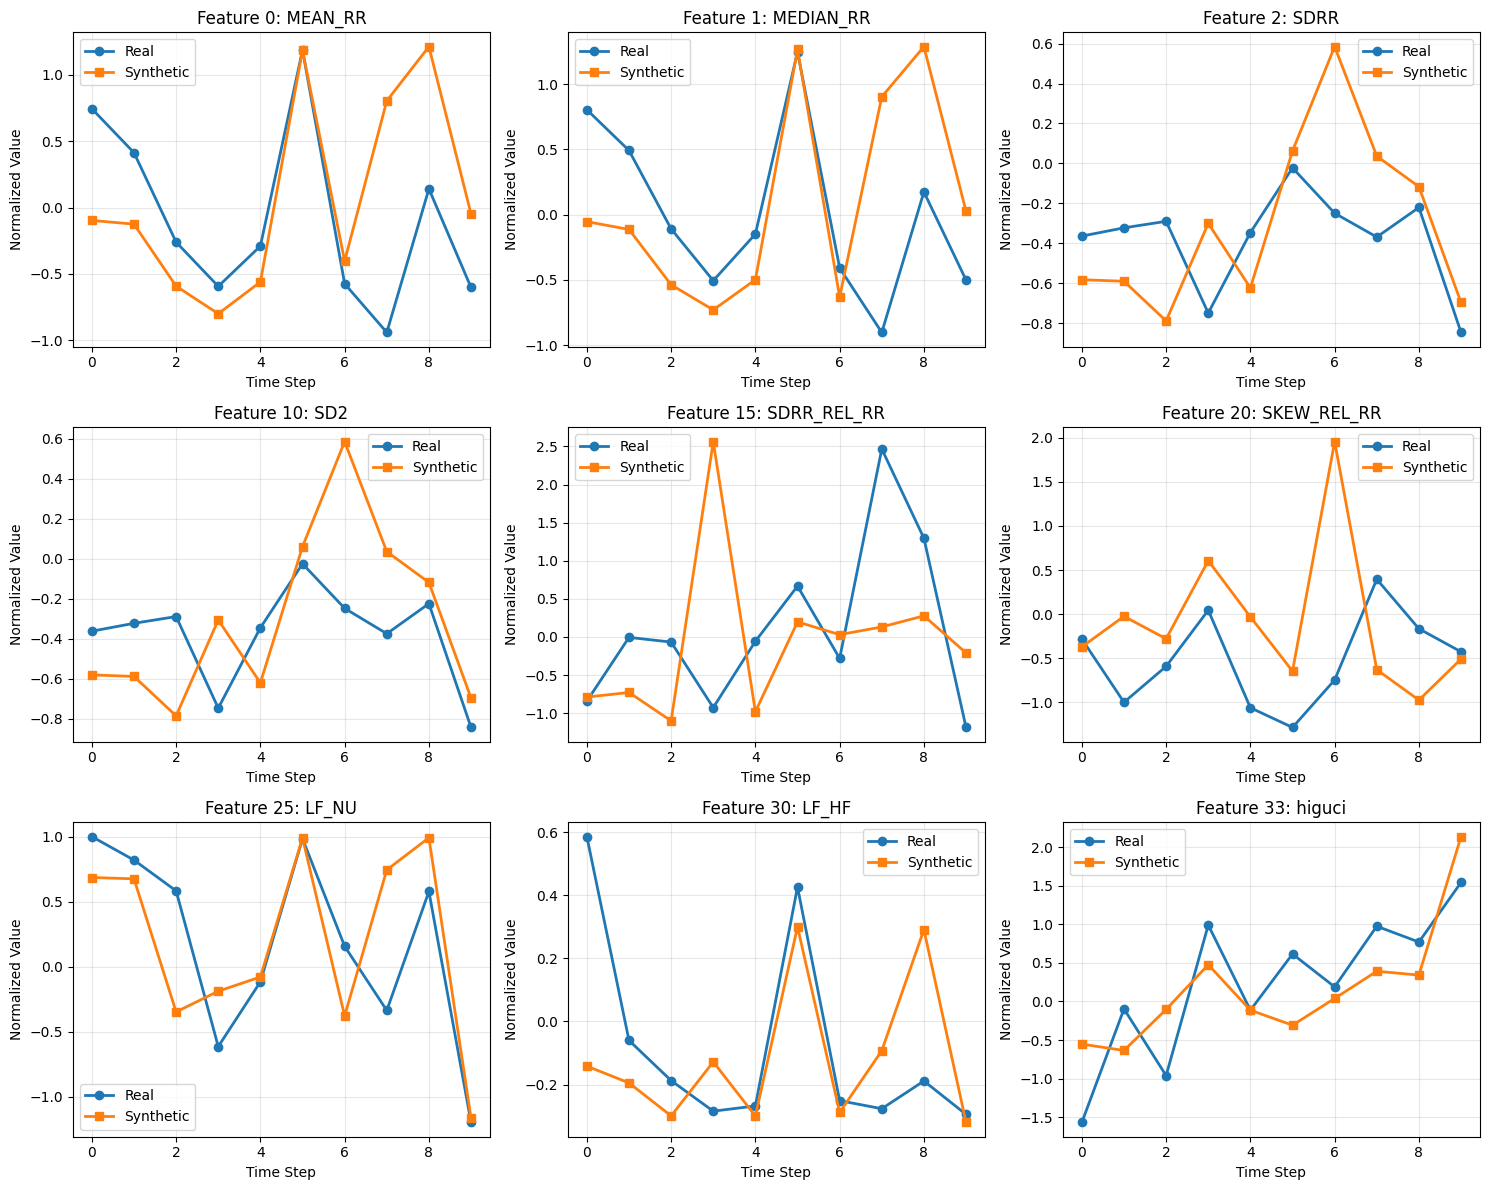

In [ ]:
# Visualize real vs synthetic data
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
feature_indices = [0, 1, 2, 10, 15, 20, 25, 30, 33]  # Sample features

for idx, feat_idx in enumerate(feature_indices):
    ax = axes[idx // 3, idx % 3]

    # Real data
    real_sample = train_sequences[0, :, feat_idx]
    ax.plot(real_sample, label='Real', linewidth=2, marker='o')

    # Synthetic data
    synth_sample = synthetic_sequences[0, :, feat_idx]
    ax.plot(synth_sample, label='Synthetic', linewidth=2, marker='s')

    ax.set_title(f'Feature {feat_idx}: {feature_columns[feat_idx]}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Normalized Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('real_vs_synthetic_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save synthetic data
# Reshape to 2D for saving as CSV
synthetic_flat = synthetic_sequences.reshape(-1, n_features)
synthetic_labels_flat = np.repeat(synthetic_labels, SEQ_LENGTH)

# Denormalize
synthetic_denormalized = scaler.inverse_transform(synthetic_flat)

# Create DataFrame
synthetic_df = pd.DataFrame(synthetic_denormalized, columns=feature_columns)
synthetic_df['condition_encoded'] = synthetic_labels_flat
synthetic_df['condition'] = label_encoder.inverse_transform(synthetic_labels_flat)

# Save
synthetic_df.to_csv('synthetic_swell_data.csv', index=False)
print("Synthetic data saved to 'synthetic_swell_data.csv'")
print(f"Shape: {synthetic_df.shape}")

Synthetic data saved to 'synthetic_swell_data.csv'
Shape: (738540, 37)


## 7. Train Classifier on Synthetic Data

In [ ]:
# Prepare data for classification
# Use mean of sequences as features (or flatten)
def prepare_for_classification(sequences, labels):
    """Convert sequences to fixed-size features"""
    # Option 1: Use mean of sequence
    features_mean = sequences.mean(axis=1)

    # Option 2: Use std of sequence
    features_std = sequences.std(axis=1)

    # Combine
    features = np.concatenate([features_mean, features_std], axis=1)
    return features

# Prepare training data (SYNTHETIC)
X_train_synthetic = prepare_for_classification(synthetic_sequences, synthetic_labels)
y_train_synthetic = synthetic_labels

# Prepare test data (REAL)
X_test_real = prepare_for_classification(test_sequences, test_seq_labels)
y_test_real = test_seq_labels

print(f"Synthetic training features: {X_train_synthetic.shape}")
print(f"Real test features: {X_test_real.shape}")

Synthetic training features: (73854, 70)
Real test features: (8202, 70)


In [ ]:
# Train Random Forest Classifier
print("\n" + "="*50)
print("Training Random Forest on SYNTHETIC data...")
print("="*50)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_synthetic, y_train_synthetic)

# Test on REAL data
y_pred_rf = rf_classifier.predict(X_test_real)
rf_accuracy = accuracy_score(y_test_real, y_pred_rf)
rf_f1 = f1_score(y_test_real, y_pred_rf, average='weighted')

print(f"\n✓ Random Forest Results:")
print(f"  Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"  F1-Score: {rf_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_real, y_pred_rf,
                          target_names=label_encoder.classes_))


Training Random Forest on SYNTHETIC data...

✓ Random Forest Results:
  Accuracy: 0.8775 (87.75%)
  F1-Score: 0.8780

Classification Report:
               precision    recall  f1-score   support

 interruption       0.80      0.93      0.86      2355
    no stress       0.95      0.83      0.88      4430
time pressure       0.84      0.95      0.89      1417

     accuracy                           0.88      8202
    macro avg       0.86      0.90      0.88      8202
 weighted avg       0.89      0.88      0.88      8202



In [ ]:
# Train MLP Classifier
print("\n" + "="*50)
print("Training MLP Neural Network on SYNTHETIC data...")
print("="*50)

mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                              activation='relu',
                              max_iter=200,
                              random_state=42)
mlp_classifier.fit(X_train_synthetic, y_train_synthetic)

# Test on REAL data
y_pred_mlp = mlp_classifier.predict(X_test_real)
mlp_accuracy = accuracy_score(y_test_real, y_pred_mlp)
mlp_f1 = f1_score(y_test_real, y_pred_mlp, average='weighted')

print(f"\n✓ MLP Results:")
print(f"  Accuracy: {mlp_accuracy:.4f} ({mlp_accuracy*100:.2f}%)")
print(f"  F1-Score: {mlp_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_real, y_pred_mlp,
                          target_names=label_encoder.classes_))


Training MLP Neural Network on SYNTHETIC data...

✓ MLP Results:
  Accuracy: 0.9188 (91.88%)
  F1-Score: 0.9188

Classification Report:
               precision    recall  f1-score   support

 interruption       0.89      0.89      0.89      2355
    no stress       0.92      0.94      0.93      4430
time pressure       0.97      0.89      0.93      1417

     accuracy                           0.92      8202
    macro avg       0.93      0.91      0.92      8202
 weighted avg       0.92      0.92      0.92      8202



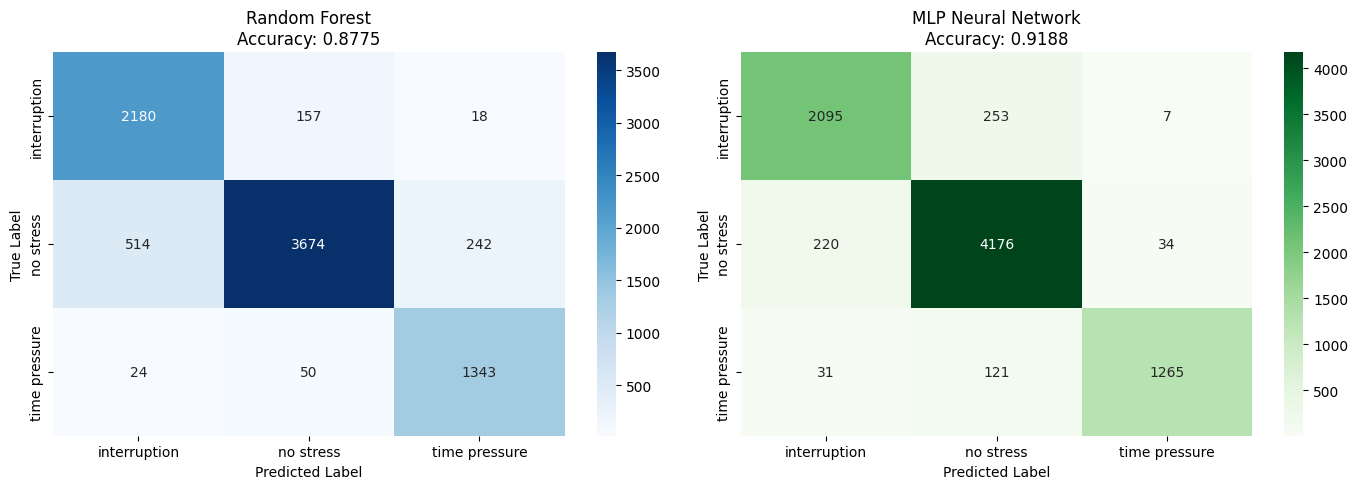

In [ ]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
cm_rf = confusion_matrix(y_test_real, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0])
axes[0].set_title(f'Random Forest\nAccuracy: {rf_accuracy:.4f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# MLP
cm_mlp = confusion_matrix(y_test_real, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[1])
axes[1].set_title(f'MLP Neural Network\nAccuracy: {mlp_accuracy:.4f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Comparison: Baseline (Train on Real Data)

In [ ]:
# For comparison, train on real data
X_train_real = prepare_for_classification(train_sequences, train_seq_labels)
y_train_real = train_seq_labels

print("\n" + "="*50)
print("BASELINE: Training on REAL data for comparison")
print("="*50)

rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_real, y_train_real)
y_pred_baseline = rf_baseline.predict(X_test_real)
baseline_accuracy = accuracy_score(y_test_real, y_pred_baseline)
baseline_f1 = f1_score(y_test_real, y_pred_baseline, average='weighted')

print(f"\n✓ Baseline (Real Data) Results:")
print(f"  Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"  F1-Score: {baseline_f1:.4f}")


BASELINE: Training on REAL data for comparison

✓ Baseline (Real Data) Results:
  Accuracy: 0.9665 (96.65%)
  F1-Score: 0.9665



FINAL RESULTS COMPARISON
                          Model  Accuracy  F1-Score
      Random Forest (Synthetic)  0.877469  0.877955
                MLP (Synthetic)  0.918800  0.918773
Random Forest (Real - Baseline)  0.966472  0.966458


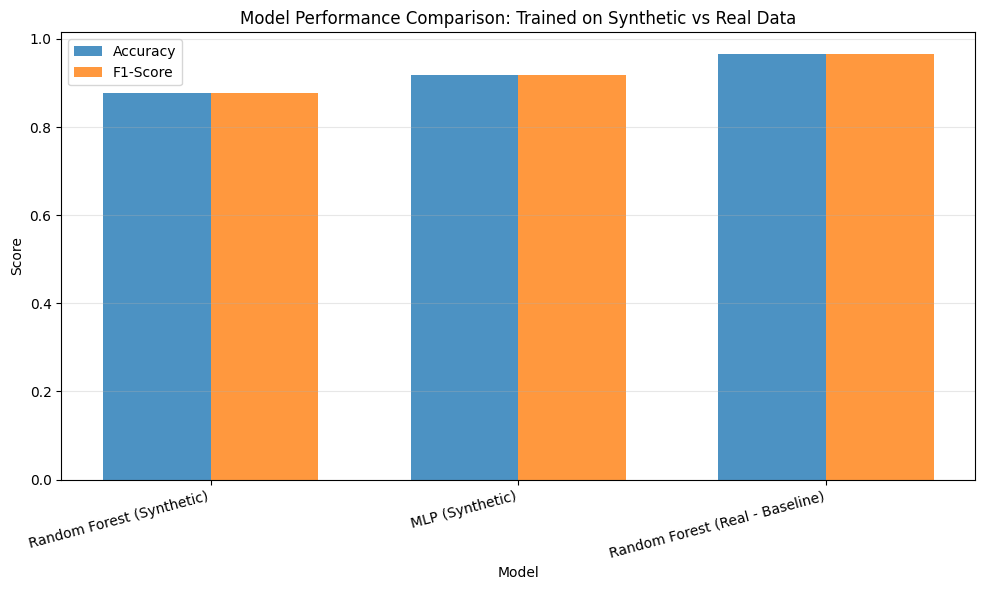

In [ ]:
# Compare results
results_comparison = pd.DataFrame({
    'Model': ['Random Forest (Synthetic)', 'MLP (Synthetic)', 'Random Forest (Real - Baseline)'],
    'Accuracy': [rf_accuracy, mlp_accuracy, baseline_accuracy],
    'F1-Score': [rf_f1, mlp_f1, baseline_f1]
})

print("\n" + "="*60)
print("FINAL RESULTS COMPARISON")
print("="*60)
print(results_comparison.to_string(index=False))
print("="*60)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_comparison))
width = 0.35

ax.bar(x - width/2, results_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x + width/2, results_comparison['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison: Trained on Synthetic vs Real Data')
ax.set_xticks(x)
ax.set_xticklabels(results_comparison['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Simple Demo UI (for Video)

In [ ]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'label_encoder': label_encoder,
    'rf_classifier': rf_classifier,
    'mlp_classifier': mlp_classifier
}, 'swell_synthetic_model.pth')

print("Model and classifiers saved!")

Model and classifiers saved!



DEMO: Generating 3 synthetic samples for 'interruption'

📊 RESULTS:
  Input Condition: interruption
  Generated Samples: 3

  Random Forest Predictions:
    Sample 1: interruption
    Sample 2: no stress
    Sample 3: interruption

  MLP Predictions:
    Sample 1: interruption
    Sample 2: interruption
    Sample 3: interruption


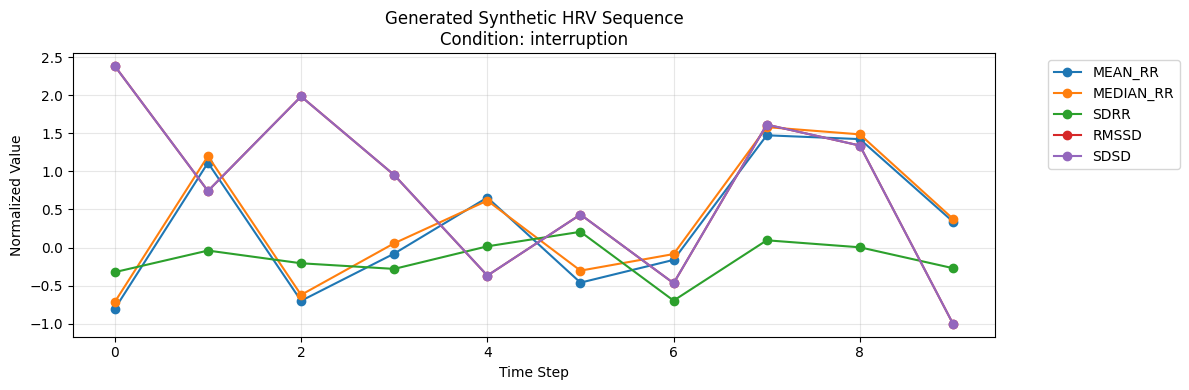


✓ Demo completed!

DEMO: Generating 3 synthetic samples for 'no stress'

📊 RESULTS:
  Input Condition: no stress
  Generated Samples: 3

  Random Forest Predictions:
    Sample 1: no stress
    Sample 2: no stress
    Sample 3: no stress

  MLP Predictions:
    Sample 1: no stress
    Sample 2: no stress
    Sample 3: no stress


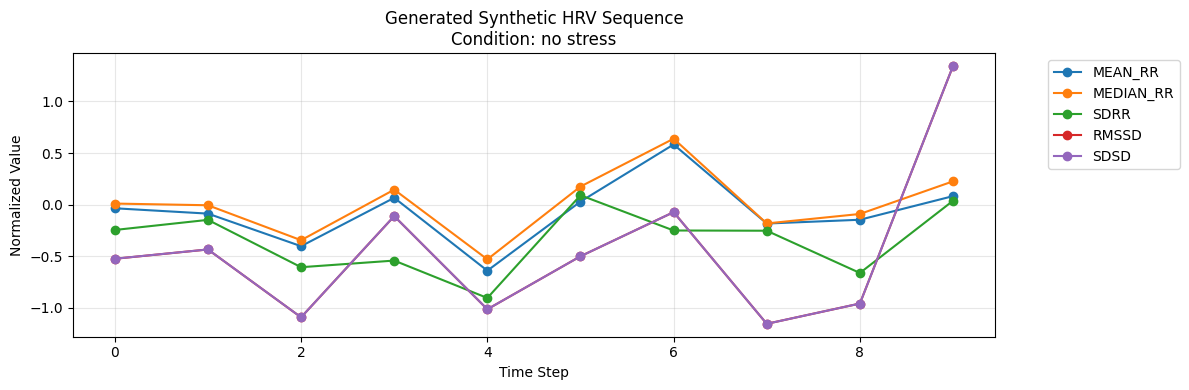


✓ Demo completed!

DEMO: Generating 3 synthetic samples for 'time pressure'

📊 RESULTS:
  Input Condition: time pressure
  Generated Samples: 3

  Random Forest Predictions:
    Sample 1: time pressure
    Sample 2: time pressure
    Sample 3: time pressure

  MLP Predictions:
    Sample 1: time pressure
    Sample 2: time pressure
    Sample 3: time pressure


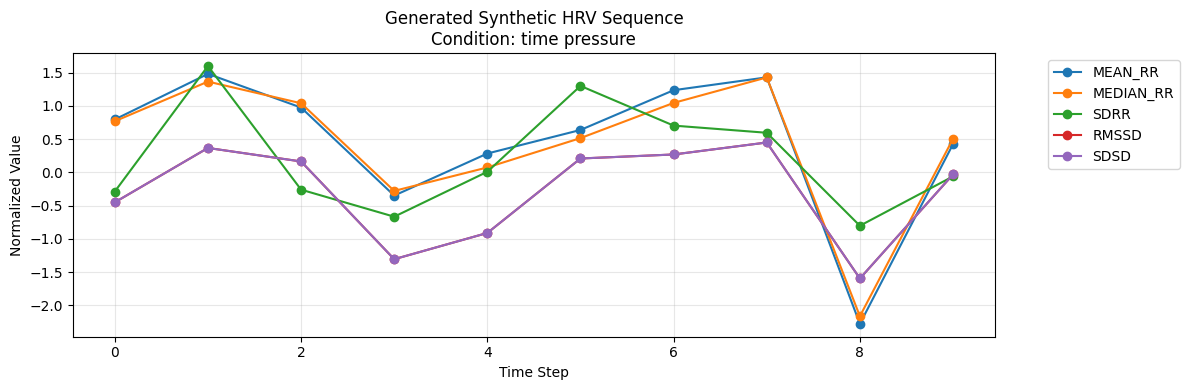


✓ Demo completed!


In [ ]:
# Interactive demo function
def demo_prediction(condition_name, num_samples=5):
    """
    Demo: Generate synthetic data and predict stress condition
    """
    print("\n" + "="*60)
    print(f"DEMO: Generating {num_samples} synthetic samples for '{condition_name}'")
    print("="*60)

    # Get condition index
    condition_idx = label_encoder.transform([condition_name])[0]

    # Generate synthetic data
    synth_data = generate_synthetic_data(model, num_samples, condition_idx, SEQ_LENGTH, n_features)

    # Prepare for classification
    X_demo = prepare_for_classification(synth_data, np.array([condition_idx]*num_samples))

    # Predict using both classifiers
    predictions_rf = rf_classifier.predict(X_demo)
    predictions_mlp = mlp_classifier.predict(X_demo)

    print("\n📊 RESULTS:")
    print(f"  Input Condition: {condition_name}")
    print(f"  Generated Samples: {num_samples}")
    print(f"\n  Random Forest Predictions:")
    for i, pred in enumerate(predictions_rf):
        print(f"    Sample {i+1}: {label_encoder.inverse_transform([pred])[0]}")

    print(f"\n  MLP Predictions:")
    for i, pred in enumerate(predictions_mlp):
        print(f"    Sample {i+1}: {label_encoder.inverse_transform([pred])[0]}")

    # Visualize one sample
    plt.figure(figsize=(12, 4))
    sample_to_plot = synth_data[0]  # First sequence

    for i in range(min(5, n_features)):
        plt.plot(sample_to_plot[:, i], label=f'{feature_columns[i]}', marker='o')

    plt.title(f'Generated Synthetic HRV Sequence\nCondition: {condition_name}')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'demo_{condition_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ Demo completed!")
    print("="*60)

# Run demos for each condition
for condition in label_encoder.classes_:
    demo_prediction(condition, num_samples=3)

## 10. Summary and Key Results

In [ ]:
print("\n" + "#"*70)
print("#" + " "*68 + "#")
print("#" + "  SWELL SYNTHETIC DATA GENERATION - FINAL SUMMARY".center(68) + "#")
print("#" + " "*68 + "#")
print("#"*70)

print("\n PROJECT DETAILS:")
print(f"   Dataset: SWELL HRV (Heart Rate Variability)")
print(f"   Features: {n_features} HRV features")
print(f"   Conditions: {list(label_encoder.classes_)}")
print(f"   Sequence Length: {SEQ_LENGTH} minutes")

print("\n DATA STATISTICS:")
print(f"   Training Sequences: {len(train_sequences)}")
print(f"   Test Sequences: {len(test_sequences)}")
print(f"   Synthetic Sequences Generated: {len(synthetic_sequences)}")

print("\n MODEL PERFORMANCE (Trained on SYNTHETIC, Tested on REAL):")
print(f"   Random Forest:  Accuracy = {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"   MLP Network:    Accuracy = {mlp_accuracy:.4f} ({mlp_accuracy*100:.2f}%)")
print(f"   Baseline (Real): Accuracy = {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")




######################################################################
#                                                                    #
#           SWELL SYNTHETIC DATA GENERATION - FINAL SUMMARY          #
#                                                                    #
######################################################################

 PROJECT DETAILS:
   Dataset: SWELL HRV (Heart Rate Variability)
   Features: 35 HRV features
   Conditions: ['interruption', 'no stress', 'time pressure']
   Sequence Length: 10 minutes

 DATA STATISTICS:
   Training Sequences: 73854
   Test Sequences: 8202
   Synthetic Sequences Generated: 73854

 MODEL PERFORMANCE (Trained on SYNTHETIC, Tested on REAL):
   Random Forest:  Accuracy = 0.8775 (87.75%)
   MLP Network:    Accuracy = 0.9188 (91.88%)
   Baseline (Real): Accuracy = 0.9665 (96.65%)


In [ ]:
# from google.colab import files
# import os

# # List of image files to download
# image_files = [
#     'training_history.png',
#     'real_vs_synthetic_comparison.png',
#     'confusion_matrices.png',
#     'results_comparison.png',
#     # Demo plots, check if they exist
#     'demo_interruption.png',
#     'demo_no stress.png',
#     'demo_time pressure.png'
# ]

# print("Attempting to download generated image plots...")
# for filename in image_files:
#     if os.path.exists(filename):
#         try:
#             files.download(filename)
#             print(f"Downloaded: {filename}")
#         except Exception as e:
#             print(f"Error downloading {filename}: {e}")
#     else:
#         print(f"Skipping {filename}: File not found.")

# print("Download process for image plots completed.")

Attempting to download generated image plots...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: training_history.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: real_vs_synthetic_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: confusion_matrices.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: results_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: demo_interruption.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: demo_no stress.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: demo_time pressure.png
Download process for image plots completed.


In [ ]:
# from google.colab import files

# files.download('swell_synthetic_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## t-SNE Visualization of Real Test Data

To visually inspect the separability of the different stress conditions in a lower-dimensional space, we will use t-distributed Stochastic Neighbor Embedding (t-SNE). This technique is effective for visualizing high-dimensional data in 2D or 3D, highlighting clusters or distinctions between classes.

Applying t-SNE to real test data...


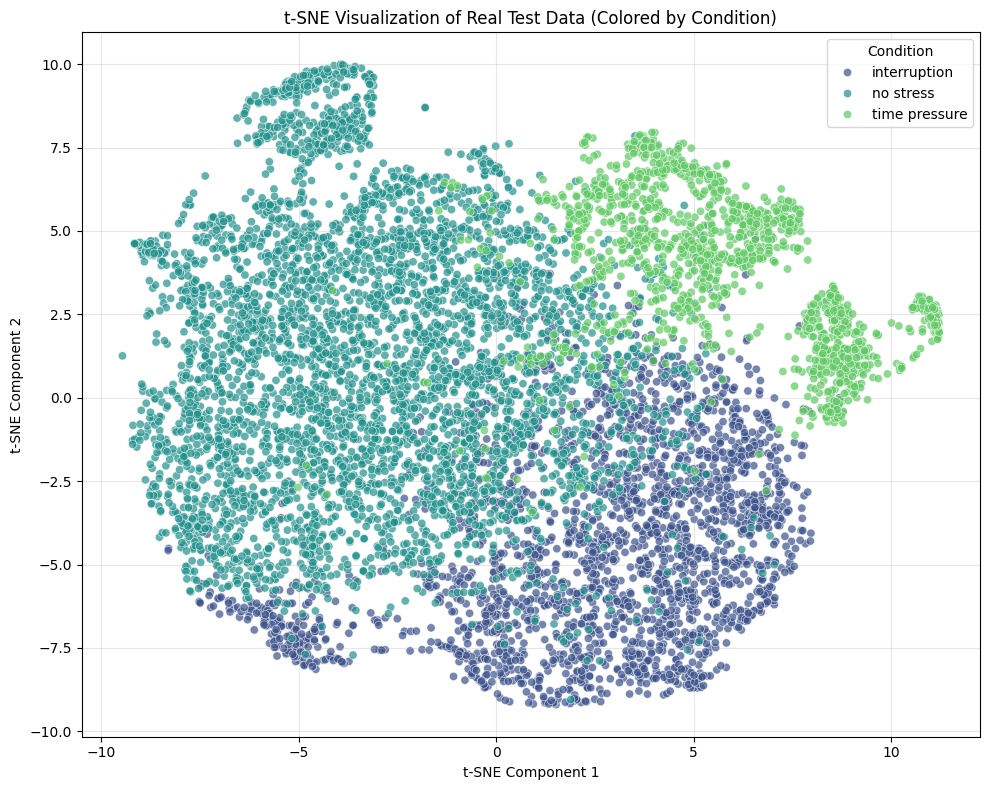

t-SNE visualization complete and saved to 'tsne_visualization.png'.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Applying t-SNE to real test data...")

# Initialize t-SNE model
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)

# Fit and transform the data
X_tsne = tsne.fit_transform(X_test_real)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Condition'] = label_encoder.inverse_transform(y_test_real)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE1', y='TSNE2', hue='Condition',
    palette=sns.color_palette('viridis', n_colors=len(label_encoder.classes_)),
    data=tsne_df, legend='full', alpha=0.7
)
plt.title('t-SNE Visualization of Real Test Data (Colored by Condition)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("t-SNE visualization complete and saved to 'tsne_visualization.png'.")

Generating condition-specific t-SNE visualizations for real vs. synthetic data...

Processing condition: interruption
Found 2355 real samples for 'interruption'.
Generating 2000 synthetic samples for 'interruption'...
Applying t-SNE with perplexity=30...


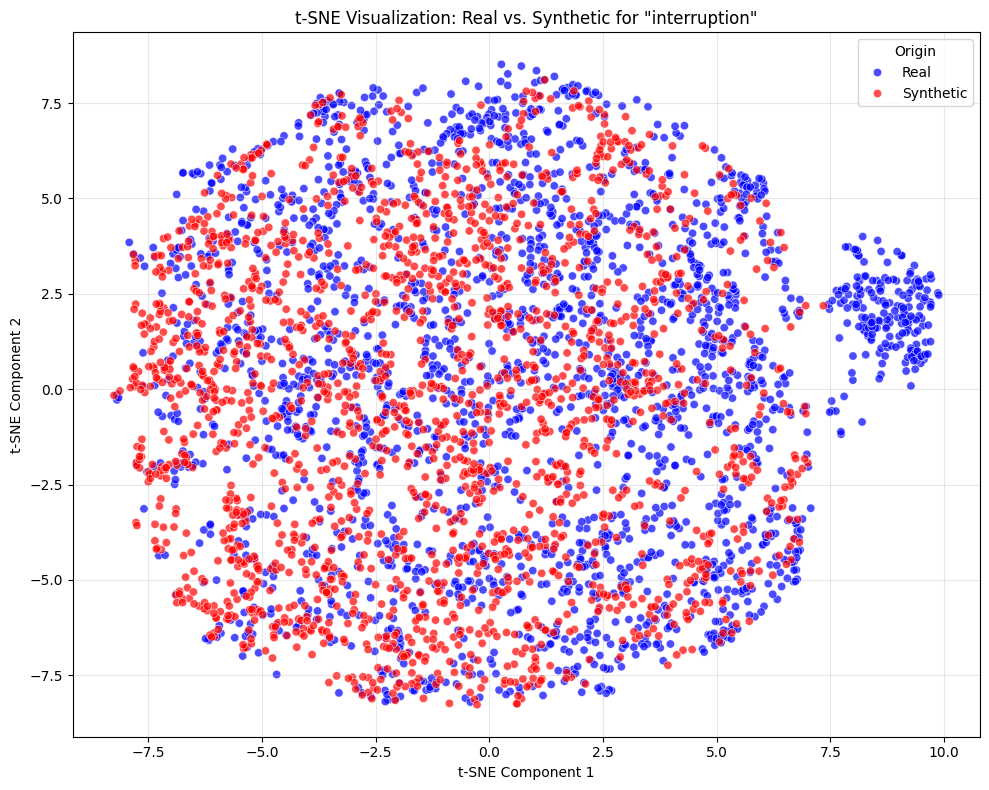

Saved t-SNE plot to 'tsne_real_vs_synthetic_interruption.png'.

Processing condition: no stress
Found 4430 real samples for 'no stress'.
Generating 2000 synthetic samples for 'no stress'...
Applying t-SNE with perplexity=30...


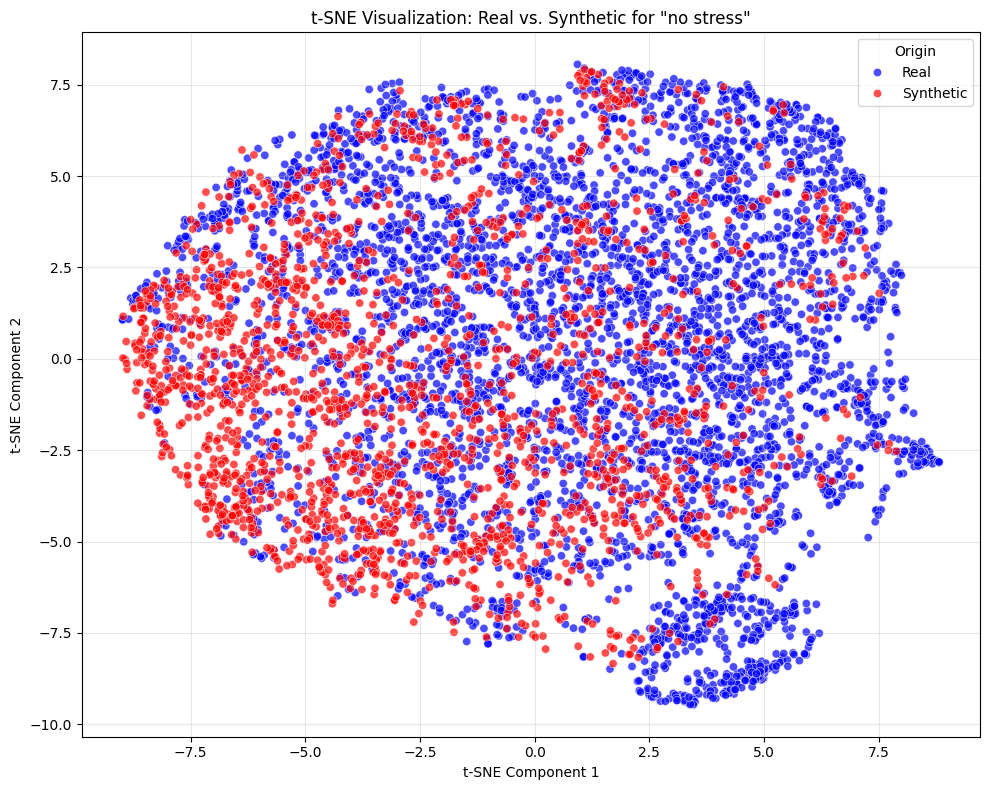

Saved t-SNE plot to 'tsne_real_vs_synthetic_no_stress.png'.

Processing condition: time pressure
Found 1417 real samples for 'time pressure'.
Generating 1417 synthetic samples for 'time pressure'...
Applying t-SNE with perplexity=30...


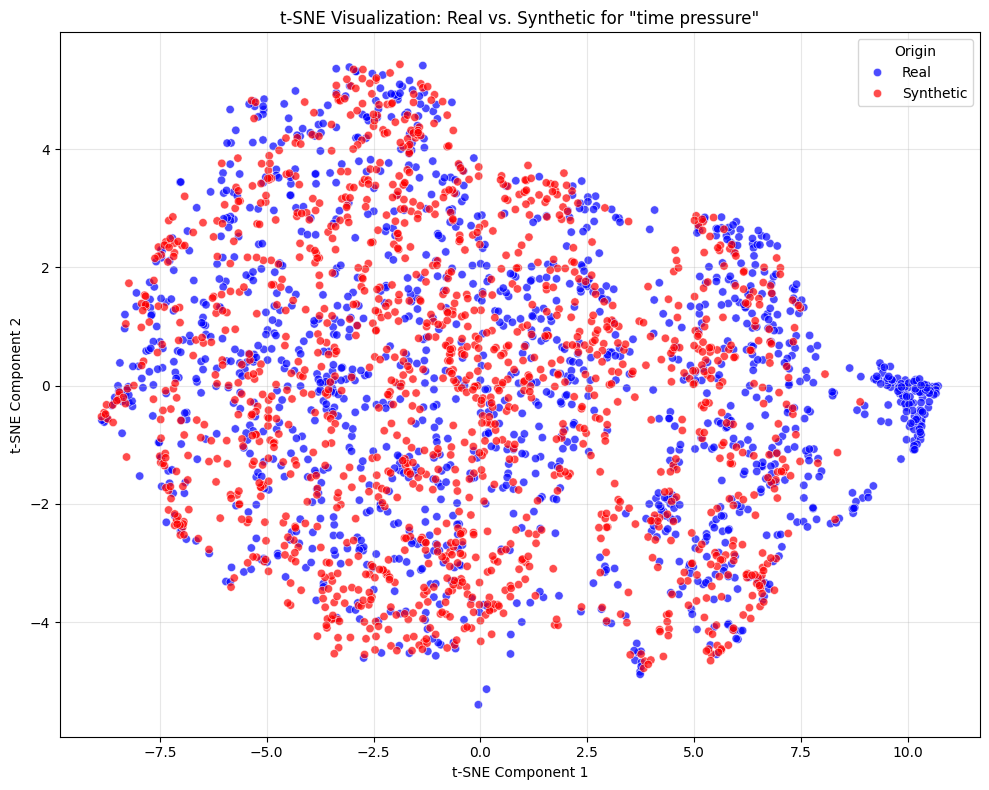

Saved t-SNE plot to 'tsne_real_vs_synthetic_time_pressure.png'.

All condition-specific t-SNE visualizations complete.


In [ ]:
print("Generating condition-specific t-SNE visualizations for real vs. synthetic data...")

for condition_idx in range(NUM_CONDITIONS):
    condition_name = label_encoder.inverse_transform([condition_idx])[0]
    print(f"\nProcessing condition: {condition_name}")

    # 3a. Filter real test data for the current condition
    real_mask = y_test_real == condition_idx
    X_real_condition = X_test_real[real_mask]
    y_real_condition = y_test_real[real_mask]

    # 3b. Determine number of real samples
    num_real_samples = len(X_real_condition)
    if num_real_samples == 0:
        print(f"No real test samples found for condition '{condition_name}'. Skipping.")
        continue
    else:
        print(f"Found {num_real_samples} real samples for '{condition_name}'.")

    # 3c. Generate comparable number of synthetic data sequences
    # Ensure the number of generated samples doesn't exceed 2000 for t-SNE performance/visualization clarity
    num_synthetic_to_generate = min(num_real_samples, 2000)
    if num_synthetic_to_generate == 0:
        print(f"Not enough real samples to generate synthetic for t-SNE visualization for '{condition_name}'. Skipping.")
        continue

    print(f"Generating {num_synthetic_to_generate} synthetic samples for '{condition_name}'...")
    # The generate_synthetic_data function expects `num_samples` as its first argument
    synth_sequences_condition = generate_synthetic_data(model, num_synthetic_to_generate, condition_idx, SEQ_LENGTH, n_features)

    # 3d. Transform synthetic sequences for classification
    X_synthetic_condition = prepare_for_classification(synth_sequences_condition, np.array([condition_idx]*num_synthetic_to_generate))

    # 3e. Combine real and synthetic data
    combined_features = np.vstack([X_real_condition, X_synthetic_condition])

    # 3f. Create corresponding labels
    origin_labels = ['Real'] * num_real_samples + ['Synthetic'] * num_synthetic_to_generate

    # 3g. Apply t-SNE
    # Adjust perplexity based on the number of samples
    perplexity_val = min(30, len(combined_features) - 1)
    if perplexity_val <= 1:
        print(f"Not enough samples ({len(combined_features)}) for t-SNE for '{condition_name}'. Skipping.")
        continue

    print(f"Applying t-SNE with perplexity={perplexity_val}...")
    tsne_viz = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, n_iter=300, learning_rate='auto', init='random')
    X_tsne_combined = tsne_viz.fit_transform(combined_features)

    # 3h. Create DataFrame for plotting
    tsne_combined_df = pd.DataFrame(data=X_tsne_combined, columns=['TSNE1', 'TSNE2'])
    tsne_combined_df['Origin'] = origin_labels
    tsne_combined_df['Condition'] = condition_name

    # 3i, 3j, 3k, 3l. Generate and save plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='TSNE1', y='TSNE2', hue='Origin',
        palette={'Real': 'blue', 'Synthetic': 'red'},
        data=tsne_combined_df, legend='full', alpha=0.7
    )
    plt.title(f't-SNE Visualization: Real vs. Synthetic for "{condition_name}"')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    filename = f'tsne_real_vs_synthetic_{condition_name.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved t-SNE plot to '{filename}'.")

print("\nAll condition-specific t-SNE visualizations complete.")